The goal here is to calculate the overlap of the baseline footprint vs. the proposed footprint (WFD, nonWFD/nonDD) with DESI. We calculate the overlap area and save the fieldIds that lie in the overlap region.

In [1]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pickle
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
# need some routines developed for LSSTDESC/ObsStrat/
import sys
sys.path.insert(0, '/global/homes/a/awan/LSST/lsstRepos/ObsStrat/code/modifyWFD/')
import helpers

# lets just ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
fontsize = 16
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.labelsize'] = fontsize
mpl.rcParams['xtick.labelsize'] = fontsize-2
mpl.rcParams['ytick.labelsize'] = fontsize-2
mpl.rcParams['legend.fontsize'] = fontsize-2
mpl.rcParams['axes.titlesize'] = fontsize
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.titlesize'] = fontsize

**Set up**

In [3]:
fids_file = '../field_list.csv'   # in this repo
outdir = '/global/cscratch1/sd/awan/lsst_output/moar_area_output/'

# data dir for DESI footprint
# saved by the notebooks in LSSTDESC/ObStrat/static/depth_cuts/overlaps
footprint_dir = '/global/homes/a/awan/desc/4most-tides_desi_data/'

# path + tags to read in coadd data for the dbs; saved data has masks for each band.
#file_yearTag = 'fullSurveyPeriod'
#coadd_data_dir = '/global/cscratch1/sd/awan/lsst_output/coadd_output_noDith/'

bands = ['u', 'g', 'r', 'i', 'z', 'y']

**Read in the fields list ang get new WFD and non-WFD fields**

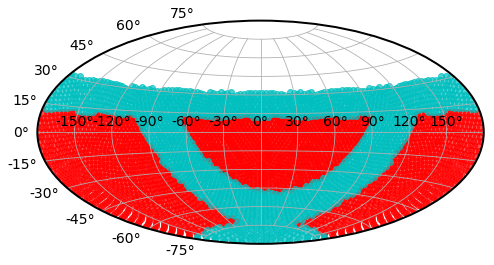

In [4]:
# Read the field list.
fields = pd.read_csv(fids_file)
# Select fields with declination between -90 and 32 -- our "big sky" footprint
bigsky = fields.query('(dec >= -90) and (dec <= 32)') 
wfd = fields.query('(dec >= -72.25) and (dec <= 12.4) and ((gb >= 15) or (gb <= -15))')
nonwfd = bigsky.query('((dec < -72.25) or (dec > 12.4)) or ((gb < 15) and (gb > -15))')

# Plot the fields so we can check what this footprint looks like.
def radec2project(ra, dec):
    return (np.radians(ra) - np.pi, np.radians(dec))

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection="aitoff")
x, y = radec2project(wfd.ra, wfd.dec)
ax.scatter(x, y, alpha=0.7, color='r')

x, y = radec2project(nonwfd.ra, nonwfd.dec)
ax.scatter(x, y, alpha=0.7, color='c')
plt.grid(True)
plt.show()

**Read in the mapping between fieldIds and HEALPix pixels (saved by get_fieldid_pixels_mapping)**

In [5]:
# read in the dictionary with keys=fid
file = 'pixels_in_fieldid_nside256.pickle'
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
pix_fid_dict = pickle.load(open('%s%s'%(outdir, file), "rb"))

# -----------------------------------
# get the healpix pixels for all the fieldsIDs in BigWFD
pix_list = []
for fid in wfd.fieldId:
    pix_list += pix_fid_dict[fid]
pix_list = np.unique(pix_list)

# -----------------------------------
# save the pixel list
footprint_pixels = {}
footprint_pixels['BigWFD'] = pix_list

# get the healpix pixels for all the fieldsIDs in Big nonWFD
pix_list = []
for fid in nonwfd.fieldId:
    pix_list += pix_fid_dict[fid]
pix_list = np.unique(pix_list)

# save the pixel list
footprint_pixels['Big-nonWFD'] = pix_list

# -----------------------------------
# read in the dictionary with keys=pixels for later
file = 'fieldid_in_pixels_nside256.pickle'
print('Reading in %s:'%file)
nside = int(file.split('nside')[-1].split('.pickle')[0])
print('Nside: %s'%nside)
fid_pix_dict = pickle.load(open('%s/%s'%(outdir, file), "rb"))

Reading in pixels_in_fieldid_nside256.pickle:
Nside: 256
Reading in fieldid_in_pixels_nside256.pickle:
Nside: 256


**Read in the DESI footprint**

In [6]:
key = 'DESI'
# read in the DESI footprints 
for i, file in enumerate([f for f in os.listdir(footprint_dir) if f.startswith(key)]):
    if i>0: raise ValueError('Somethings wrong.')
    print('Reading %s'%file)
    print('nside: %s'%int(file.split('nside')[-1].split('_')[0]))
    footprint_pixels[key] = pd.read_csv('%s/%s'%(footprint_dir, file))['pixNum'].values

Reading DESI_pixels_nside256_ring.csv
nside: 256


**Read in the baseline2018a footprints**

In [7]:
# read in the pixels for all-band WFD 
file = 'baseline2018a_all-band_wfd_pixels_nside256.csv'
print('Reading %s'%file)
footprint_pixels['all-band baseline2018a WFD'] = pd.read_csv('%s/%s'%(outdir, file))['pixels'].values

# read in the pixels for any-band non-WFD
file = 'baseline2018a_any-band_nonwfd_nondd_pixels_nside256.csv'
print('Reading %s'%file)
footprint_pixels['any-band baseline2018a nonWFD, nonDD'] = pd.read_csv('%s/%s'%(outdir, file))['pixels'].values

Reading baseline2018a_all-band_wfd_pixels_nside256.csv
Reading baseline2018a_any-band_nonwfd_nondd_pixels_nside256.csv


**Lets plot all the footprints that we have so far**

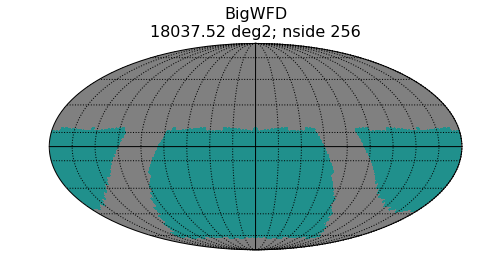

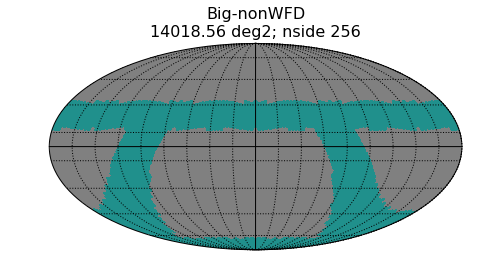

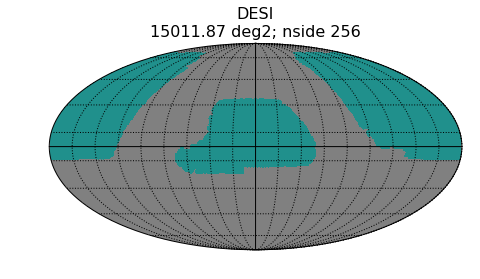

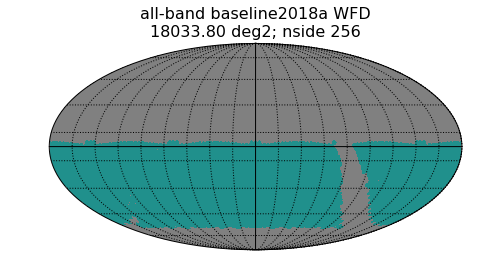

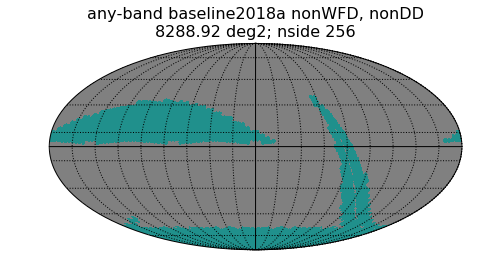

In [8]:
for key in footprint_pixels:
    helpers.plot_skymap_somepix(pix_list=footprint_pixels[key], nside=nside, title_append=key)

**Lets plot the figure with all the overlaps**

DESI: -19.79 <= dec <= 76.45
BigWFD: -73.68 <= dec <= 14.02
Big-nonWFD: -89.82 <= dec <= 33.51

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved DESI_vs_bigwfd_vs_bignonwfd_nside256_matplotlib.png


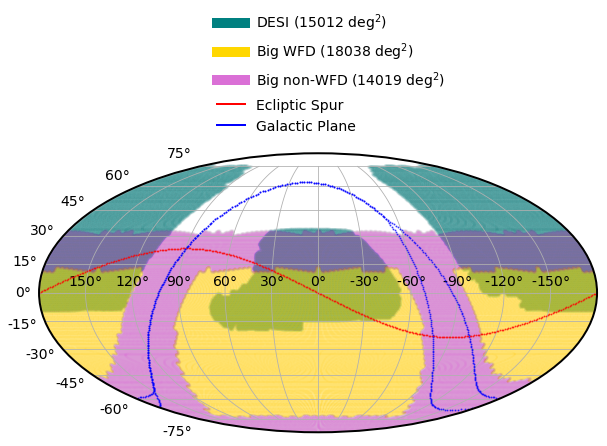

DESI: -19.79 <= dec <= 76.45
all-band baseline2018a WFD: -63.64 <= dec <= 4.33
any-band baseline2018a nonWFD, nonDD: -89.82 <= dec <= 37.54

Old labels: [-150. -120.  -90.  -60.  -30.    0.   30.   60.   90.  120.  150.]
News labels: [ 150.  120.   90.   60.   30.    0.  -30.  -60.  -90. -120. -150.]

## Saved DESI_vs_baseline2018a_wfd_nonwfd_nside256_matplotlib.png


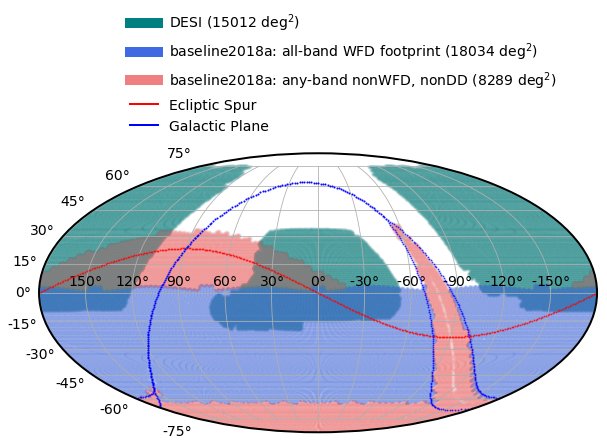

In [9]:
dbname = 'baseline2018a'
# ---------------------------------------------------------------------------------------
# plot DESI with the proposed footprint
order_list = ['DESI', 'BigWFD', 'Big-nonWFD']
order_dict = {}
for key in order_list:
    order_dict[key]= footprint_pixels[key]
    
colors = ['teal', 'gold', 'orchid']

alphas = [0.02, 0.03, 0.01]
titles = ['DESI', 'Big WFD', 'Big non-WFD']

filename = 'DESI_vs_bigwfd_vs_bignonwfd_nside%s_matplotlib.png'%(nside)
filename = '%s%s'%(outdir, filename)
helpers.plot_matplot(nside=nside, pixels_dict=order_dict, syms=['x', '_', 'o'],
                     colors=colors, alphas=alphas, titles=titles,
                     saveplot=True, fname=filename, add_ec_mw=True,
                     xcoord=0.75, ycoord=1.55)

# ---------------------------------------------------------------------------------------
# now plot DESI with baseline WFD, nonWFD
order_list = ['DESI', 'all-band %s WFD'%dbname, 'any-band %s nonWFD, nonDD'%dbname]
order_dict = {}
for key in order_list:
    order_dict[key]= footprint_pixels[key]
    
colors = ['teal', 'royalblue', 'lightcoral']

alphas = [0.02, 0.03, 0.01]
titles = ['DESI', '%s: all-band WFD footprint'%dbname, '%s: any-band nonWFD, nonDD'%dbname]

filename = 'DESI_vs_%s_wfd_nonwfd_nside%s_matplotlib.png'%(dbname, nside)
filename = '%s%s'%(outdir, filename)
helpers.plot_matplot(nside=nside, pixels_dict=order_dict, syms=['x', '_', 'o'],
                     colors=colors, alphas=alphas, titles=titles,
                     saveplot=True, fname=filename, add_ec_mw=True,
                     xcoord=0.95, ycoord=1.55)

**Lets calculate the area overlap with DESI with baseline footprint + the Big Sky**

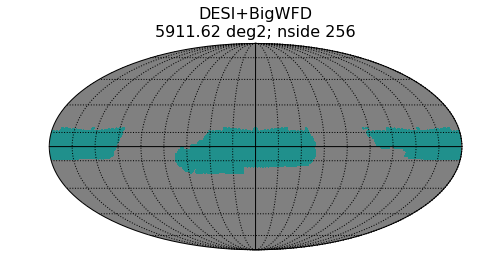

## 915 unique fields in DESI + BigWFD overlap
## Saved DESI_overlap_BigWFD_fields.csv



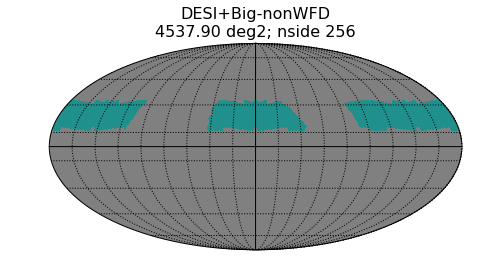

## 751 unique fields in DESI + Big-nonWFD overlap
## Saved DESI_overlap_Big-nonWFD_fields.csv



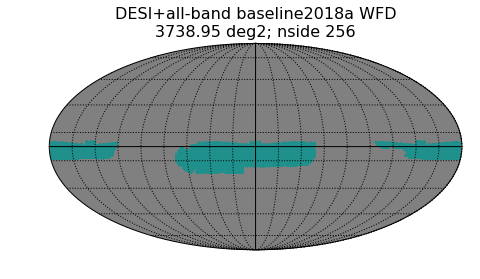

## 622 unique fields in DESI + all-band baseline2018a WFD overlap
## Saved DESI_overlap_all-band_baseline2018a_WFD_fields.csv



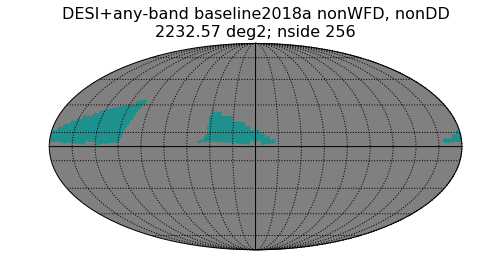

## 402 unique fields in DESI + any-band baseline2018a nonWFD, nonDD overlap
## Saved DESI_overlap_any-band_baseline2018a_nonWFD_nonDD_fields.csv

CPU times: user 3.22 s, sys: 488 ms, total: 3.71 s
Wall time: 3.23 s


In [10]:
%%time
overlap_area = {}
for key in [f for f in footprint_pixels.keys() if not f.__contains__('DESI')]:
    # find the overlapping pixels
    overlap = list( set(footprint_pixels['DESI'])- \
                   ( set(footprint_pixels['DESI'])- set(footprint_pixels[key])
                   )
                  )
    # calculate the area in the overlapping pixels and save it
    overlap_area['DESI+%s'%key] = helpers.get_area(pix_arr=overlap, nside=nside)
    # plot to check things
    helpers.plot_skymap_somepix(pix_list=overlap, nside=nside, title_append='DESI+%s'%key)

    # lets save the fieldIds for the fields in the overlap
    good_fid = []
    for pix in overlap:
        good_fid += list(fid_pix_dict[pix])
    uniq_ids = np.unique(good_fid)
    print('## %s unique fields in DESI + %s overlap'%(len(uniq_ids), key))
    if key.__contains__('nonDD'): 
        key = key.replace(', ', '_')
    fname = 'DESI_overlap_%s_fields.csv'%(key.replace(' ', '_'))
    pd.DataFrame({'fieldId': uniq_ids}).to_csv('%s/%s'%(outdir, fname), index=False)
    print('## Saved %s\n'%fname)

**Lets output an md table for the overlap area**

In [11]:
# first the overlaps + median depth
header = '| footprint | '
header2 = '| ------ | '

for i, key in enumerate([f for f in footprint_pixels.keys() if not f.__contains__('DESI')]):
    row = '| %s | '%key
    header += ' DESI overlap (deg$^2$) | '
    header2 += ' ------ | '
    row += '  %.f | '%overlap_area['DESI+%s'%(key)] 
     
    if i==0:
        print('%s\n%s'%(header, header2))
    print(row)

| footprint |  DESI overlap (deg$^2$) | 
| ------ |  ------ | 
| BigWFD |   5912 | 
| Big-nonWFD |   4538 | 
| all-band baseline2018a WFD |   3739 | 
| any-band baseline2018a nonWFD, nonDD |   2233 | 


| footprint |  DESI overlap (deg$^2$) | 
| ------ |  ------ | 
| BigWFD |   5912 | 
| Big-nonWFD |   4538 | 
| all-band baseline2018a WFD |   3739 | 
| any-band baseline2018a nonWFD, nonDD |   2233 | 